# Brain Tumor Segmentation

The brain tumor dataset used for this segmentation task is taken from [here].(https://figshare.com/articles/dataset/brain_tumor_dataset/1512427)

### Data Format
The dataset contains 3064 T1-weighted contrast-inhanced images with three kinds of brain tumor. This data is organized in **matlab data format (.mat file)**. Each file stores a struct containing the following fields for an image:

- **cjdata.label**: 1 for meningioma, 2 for glioma, 3 for pituitary tumor
- **cjdata.PID**: patient ID
- **cjdata.image**: image data
- **cjdata.tumorBorder**: a vector storing the coordinates of discrete points on tumor border.
		For example, [x1, y1, x2, y2,...] in which x1, y1 are planar coordinates on tumor border.
		It was generated by manually delineating the tumor border. So we can use it to generate
		binary image of tumor mask.
- **cjdata.tumorMask**: a binary image with 1s indicating tumor region

### Methodology
We follow the architecture of the UNet++ ([3] & [4]). UNet++, a convolutional neural network dedicated for biomedical image segmentation, was designed, and applied in 2018 by (Zhou et al., 2018). UNet++ was basically designed to overcome some of the short comings of the UNet architecture. UNet works on the idea of skip connections. U-Net concatenates them and add convolutions and non-linearities between each up-sampling block. The skip connections recover the full spatial resolution at the network output, making fully convolutional methods suitable for semantic segmentation. UNet and other segmentation models based on convolution tend to fuse semantically dissimilar feature maps from the encoder and decoder sub-networks, which may degrade segmentation performance. This is where UNet++ is shown to have an edge over the other players as it bridges the semantic gap between the feature maps of the encoder and decoder prior to fusion thus improving the segmentation performance and output.

### UNet++ Architecture

"*UNet++ consists of an encoder and decoder that are **connected through a series of nested dense convolutional blocks**. The main idea behind UNet++ is to bridge the semantic gap between the feature maps of the encoder and decoder prior to fusion.*" 

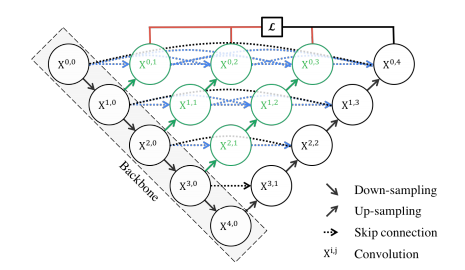

In the image above, black indicates the original U-Net pathways, green and blue show dense convolution blocks on the skip pathways, and red indicates deep supervision. Red, green, and blue components distinguish UNet++ from U-Net

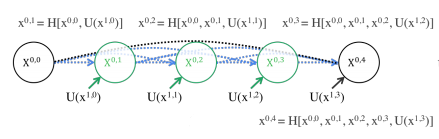

The skip pathway between nodes **X(0, 0)** and **X(1, 3)** consists of a series dense convolution block with three convolution layers where **each convolution layer is preceded by a concatenation layer that fuses the output from the previous convolution layer of the same dense block with the corresponding up-sampled output of the lower dense block**. The dense convolution block brings the semantic level of the encoder feature maps closer to that of the feature maps awaiting in the decoder. 

**Skip Pathway Formulation -**

The skip pathway if formulated as - let *x(i,j)* denote the output of node *X(i,j)* where **i indexes the down-sampling layer along the encoder** and **j indexes the convolution layer of the dense block along the skip pathway**. The stack of feature maps represented by *x(i,j)* is computed as

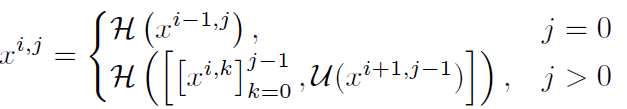

**H(·)** is a **convolution operation** followed by an activation function, **U(·)** denotes an **up-sampling layer**, and **[ ]** denotes the **concatenation layer***.

**Image Reference -** https://arxiv.org/pdf/1807.10165.pdf


**Reference:**

[1] Dataset: https://figshare.com/articles/dataset/brain_tumor_dataset/1512427 <br>
[2] Data ReadMe: https://ndownloader.figshare.com/files/7953679 <br>
[3] UNet++ Paper 1: https://arxiv.org/pdf/1807.10165.pdf <br>
[4] UNet++ Paper 2: https://arxiv.org/pdf/1912.05074.pdf

## Implementation

### Import Packages & Custom Libraries

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

from UNetPPDataGenerator import ImageDataGen
from UNetPP import UNetPlusPlus
from ImageDataExtractor import ImageDataExtractor

### Download & Extract Data

In [2]:
dataExtractor = ImageDataExtractor(RemoveTemporaryFiles = True)
MAT_DATA_PATH, IMG_DATA_PATH, MASK_DATA_PATH, DATA_README_PATH = dataExtractor.downloadAndExtractImages()

>>> Downloading data to - 'data\temp\download\1512427__.zip'


>>> Download Complete...
>>> Extracting Master Folder...



>>> Extracting *.mat files...



>>> Copying the data ReadMe file to - '\data\README.txt'
>>> Data unzipped successfully to 'data\matData'
>>> Extracting images and masks...



>>> Data extraction complete...
>>> Removing the master zip file...
>>> Removing the temp folder created for download...'data\temp\download'

>>> Data loaded into the following directoies
-----------------------------------------------
>>> Mat files located @ 'data\matData'
>>> Image files located @ 'data\imgData\img'
>>> Mask files located @ 'data\imgData\mask'
>>> Data ReadMe located @ 'data\README.txt'


#### Verify the Data Paths

In [3]:
MAT_DATA_PATH, IMG_DATA_PATH, MASK_DATA_PATH, DATA_README_PATH

('data\\matData',
 'data\\imgData\\img',
 'data\\imgData\\mask',
 'data\\README.txt')

### Define Hyperparameters

In [4]:
image_size = 128
image_channels = 1
epochs = 30
batch_size = 64

# there are a total of 3064 images.
# so fixing 2900 of data available for training set
# 200 for validation set and 64 for test set.
validation_data_size = 200
test_data_size = 64
train_data_size = 2800

### Define Reusable Functions

In [5]:
def VisualizeImageAndMask(image, mask, prediction_img = None):
    
    """
    
    Displays the image, mask and the predicted mask
    of the input image.
    
    Args:
        image: the original image.
        mask: the given mask of the image.
        prediction_img: the predicted mask of the image.
        
    Return:
        None
        
    """
    fig = plt.figure()
    fig.subplots_adjust(hspace = 0.6, wspace = 0.6)
    fig.suptitle('Image & Mask(s)', fontsize = 15)
    fig.subplots_adjust(top = 1.15)
    
    ax = fig.add_subplot(1, 3, 1)
    ax.imshow(image, cmap = "gray")
    setTitleAndRemoveTicks(ax, 'Original\nImage')
    
    ax = fig.add_subplot(1, 3, 2)
    ax.imshow(mask, cmap = "gray")
    setTitleAndRemoveTicks(ax, 'Original\nMask')
    
    if prediction_img is not None:
        #prediction_img = prediction_img * 255
        ax = fig.add_subplot(1, 3, 3)
        ax.imshow(np.reshape(prediction_img, (image_size, image_size)), cmap = "gray")
        setTitleAndRemoveTicks(ax, 'Predicted\nMask')
    
def setTitleAndRemoveTicks(axes, title):
    
    """
    Sets the sub-plot title and removes the 
    x & y ticks on the respective axes.
    
    Args:
        axes: the subplot.
        title: title of the subplot.
        
    Return:
        None
        
    """
    
    # set plot title
    axes.title.set_text(title)
    
    # remove the ticks
    axes.set_xticks([])
    axes.set_yticks([])

### Prepare Data for Segmentation Task

In [6]:
# get the ids of the images.
# os.walk yields a 3-tuple (dirpath, dirnames, filenames). We need the directory names here.
# IMG_DATA_PATH = 'data\\imgData\\img'
# MASK_DATA_PATH = 'data\\imgData\\mask'
image_ids = next(os.walk(IMG_DATA_PATH))[2]
np.random.shuffle(image_ids)

# partition the data into train, test and validation sets.
testing_data_ids = image_ids[:test_data_size]
validation_data_ids = image_ids[:validation_data_size]
training_data_ids = image_ids[:train_data_size]

### Image Data Generator - Verification

In [7]:
temp_data_generator = ImageDataGen(image_ids = training_data_ids,
                                   img_path = IMG_DATA_PATH, 
                                   mask_path = MASK_DATA_PATH,
                                   batch_size = batch_size, 
                                   image_size = image_size)

# get one batch of data
images, masks = temp_data_generator.__getitem__(0)
print("Batch Dimension Details:", images.shape, masks.shape)

Batch Dimension Details: (64, 128, 128) (64, 128, 128)


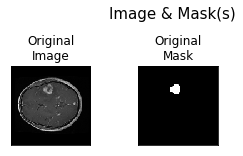

In [8]:
VisualizeImageAndMask(image = images[2], mask = masks[2])

In [9]:
temp_data_generator = None

### Model Training and Validation

#### Model Initialization & Compilation

In [10]:
# Initialize the Unet++ with the default parameters. 
# The default params are the one that were used in the original paper.
# Input shape - (512, 512, 1), 
# filters [32, 64, 128, 256, 512].
UNetPP = UNetPlusPlus(input_shape = (128, 128, 1), deep_supervision = False)

# call the build netowrk API to build the network.
model = UNetPP.BuildNetwork()

In [11]:
# compile & summarize the model
if model is not None:
    UNetPP.CompileAndSummarizeModel(model = model)

Model: "UNetPP"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
InputLayer (InputLayer)         [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv00_1 (Conv2D)               (None, 128, 128, 32) 320         InputLayer[0][0]                 
__________________________________________________________________________________________________
X00_ (Dropout)                  (None, 128, 128, 32) 0           conv00_1[0][0]                   
__________________________________________________________________________________________________
conv00_2 (Conv2D)               (None, 128, 128, 32) 9248        X00_[0][0]                       
_____________________________________________________________________________________________

#### Initialize the Data Generators

In [12]:
train_gen = ImageDataGen(image_ids = training_data_ids,
                         img_path = IMG_DATA_PATH, 
                         mask_path = MASK_DATA_PATH, 
                         image_size = image_size, 
                         batch_size = batch_size)

valid_gen = ImageDataGen(image_ids = validation_data_ids, 
                         img_path = IMG_DATA_PATH, 
                         mask_path = MASK_DATA_PATH,
                         image_size = image_size, 
                         batch_size = batch_size)

test_gen = ImageDataGen(image_ids = testing_data_ids, 
                        img_path = IMG_DATA_PATH, 
                        mask_path = MASK_DATA_PATH,
                        image_size = image_size, 
                        batch_size = batch_size)

train_steps = len(training_data_ids)//batch_size
valid_steps = len(validation_data_ids)//batch_size

In [13]:
train_steps, valid_steps

(43, 3)

#### Model Training

In [14]:
model.fit(train_gen, 
          validation_data = valid_gen, 
          steps_per_epoch = train_steps, 
          validation_steps = valid_steps, 
          epochs = epochs)

Epoch 1/30
43/43 [==============================] - 1475s 34s/step - loss: 0.8190 - acc: 0.9503 - __iou_loss_core: 0.3295 - val_loss: 0.7801 - val_acc: 0.9845 - val___iou_loss_core: 0.6199
Epoch 2/30
43/43 [==============================] - 996s 23s/step - loss: 0.6874 - acc: 0.9751 - __iou_loss_core: 0.5616 - val_loss: 0.9808 - val_acc: 0.9908 - val___iou_loss_core: 0.8625
Epoch 3/30
43/43 [==============================] - 436s 10s/step - loss: 0.6622 - acc: 0.9765 - __iou_loss_core: 0.5827 - val_loss: 0.9737 - val_acc: 0.9858 - val___iou_loss_core: 0.8323
Epoch 4/30
43/43 [==============================] - 439s 10s/step - loss: 0.6355 - acc: 0.9794 - __iou_loss_core: 0.5995 - val_loss: 0.8686 - val_acc: 0.9812 - val___iou_loss_core: 0.7302
Epoch 5/30
43/43 [==============================] - 451s 10s/step - loss: 0.6235 - acc: 0.9789 - __iou_loss_core: 0.5944 - val_loss: 0.9985 - val_acc: 0.9843 - val___iou_loss_core: 0.8677
Epoch 6/30
43/43 [==============================] - 436s 10

#### Save the Model

In [15]:
model_dir = "models"
model_name = "UNetpp_BrainTumorSegment.h5"

if not os.path.isdir(model_dir):
    os.makedirs(model_dir)

model.save_weights(os.path.join(model_dir, model_name))

In [25]:
test_gen = ImageDataGen(image_ids = testing_data_ids, 
                        img_path = IMG_DATA_PATH, 
                        mask_path = MASK_DATA_PATH,
                        image_size = image_size, 
                        batch_size = 32)

### Model Testing and Prediction Visualizations

In [28]:
# get the test set images
test_images, test_masks = test_gen.__getitem__(0)
predicted_masks = model.predict(test_images)

predicted_masks = predicted_masks > 0.5

In [29]:
test_images_2, test_masks_2 = test_gen.__getitem__(1)
predicted_masks_2 = model.predict(test_images)

predicted_masks_ = predicted_masks_2 > 0.5

#### Viz 1

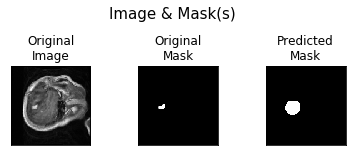

In [37]:
VisualizeImageAndMask(image = test_images_2[4], mask = test_masks_2[4], prediction_img = predicted_masks_[4])

#### Viz 2

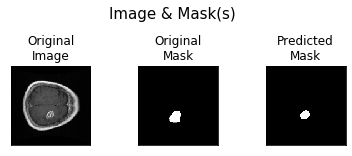

In [33]:
VisualizeImageAndMask(image = test_images[3], mask = test_masks[3], prediction_img = predicted_masks[3])

#### Viz 3

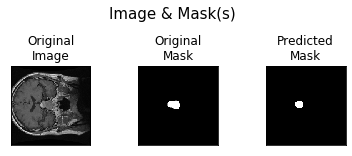

In [34]:
VisualizeImageAndMask(image = test_images[22], mask = test_masks[22], prediction_img = predicted_masks[22])

### Conclusion & Summary

Comparing the original image, original mask and the predicted mask, the model based on the UNet++ architecture is correctly able to segment the brain tumor location and generate the masks. Though there are some differences seen in the visualizations above, these can be improved with further training and fine tuning the model itself.

#### Summary
- UNet++ aims to improve segmentation accuracy, with a series of nested, dense skip pathways.
- Redesigned skip pathways make optimization easier by getting the semantically similar feature maps.
- Dense skip connections improve segmentation accuracy and make the gradient flow smoother.
- Deep supervision allows for model complexity tuning to balance between speed and performance optimisation by allowing the model to toggle between 2 different training modes in the fast mode and the accurate mode.